In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [29]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Preparando Dados

In [30]:
enem = pd.read_csv('../src/enem_total_dum_pad.csv')

enem.set_index('NU_INSCRICAO', drop=True, inplace=True)

enem.head()

,APPROVED_ADM,APPROVED_MED,TP_SEXO_M,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_ESTADO_CIVIL_1,TP_ESTADO_CIVIL_2,...,Q006_P,Q006_Q,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q005,NU_NOTA_MEDIA
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
190003903183,0,0,0,0,0,1,0,0,1,0,...,0,0,-0.406124,-0.591590,-1.175529,-1.183133,-0.595710,-3.509511,0.770488,-1.007538
190005124618,0,0,0,0,1,0,0,0,1,0,...,0,0,-0.406124,-0.770479,0.539545,0.262420,-0.957419,0.132736,0.098980,-0.355019
190001447215,0,0,0,0,0,1,0,0,0,1,...,0,0,2.379266,-0.085501,0.038743,0.072545,-0.176888,0.011327,-0.572528,-0.063061
190003825026,0,0,1,0,0,1,0,0,1,0,...,0,0,-0.684663,-1.793360,0.147136,-1.668567,-0.263614,-0.838530,0.098980,-0.917296
190001995539,0,0,0,1,0,0,0,0,1,0,...,0,0,-0.684663,0.276864,-0.077882,0.393182,0.712579,1.832451,0.770488,0.415507


In [31]:
enem.shape

(10000, 86)

In [32]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC CURVE (area = %0.2f)' % auc_value)
    plt.plot([0,1], [0,1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ROC Curve')
    plt.legend()
    plt.show()

In [33]:
X = enem.drop(['APPROVED_ADM', 'APPROVED_MED'], axis=1)
y = enem['APPROVED_ADM']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Primeiro Modelo Logístico

In [35]:
model = LogisticRegression()

In [36]:
y.value_counts()

0    8467
1    1533
Name: APPROVED_ADM, dtype: int64

In [37]:
model_fit = model.fit(X_train, y_train)

In [38]:
yhat_train = model.predict_proba(X_train)
yhat_train = yhat_train[:, 1]

In [39]:
yhat_test = model.predict_proba(X_test)
yhat_test = yhat_test[:, 1]

In [40]:
matrix = confusion_matrix(y_train, model.predict(X_train))

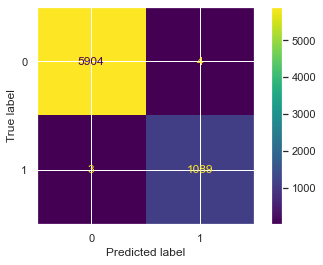

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [42]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5908
           1       1.00      1.00      1.00      1092

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000



In [43]:
print('AUC: %0.5f' % roc_auc_score(y_train, yhat_train))

AUC: 1.00000


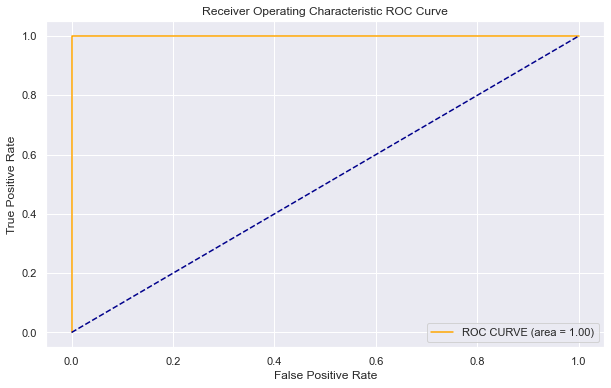

In [44]:
plot_roc_curve(y_train, yhat_train)

In [45]:
matrix = confusion_matrix(y_test, model.predict(X_test))

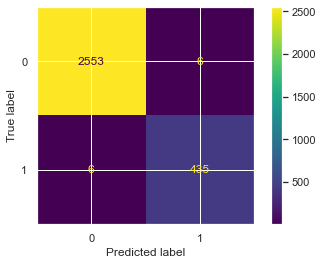

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

In [47]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2559
           1       0.99      0.99      0.99       441

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



In [48]:
print('AUC: %0.5f' % roc_auc_score(y_test, yhat_test))

AUC: 0.99987


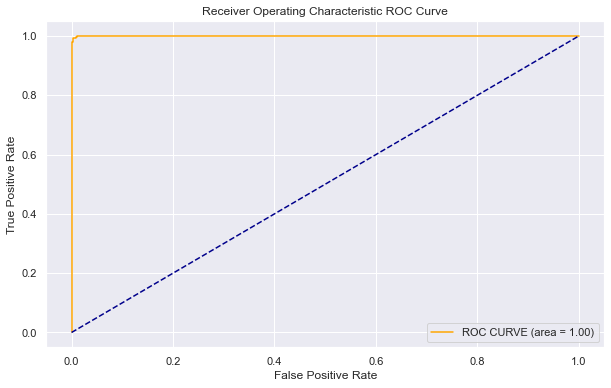

In [49]:
plot_roc_curve(y_test, yhat_test)

## Segundo Modelo Logístico com Validação Cruzada

In [50]:
test_size = 0.20
np.random.seed(7)
scoring = 'accuracy'
num_folds = 10
solver = 'newton-cg'

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

In [52]:
model = LogisticRegression(solver = solver)

In [53]:
kfold = KFold(n_splits = num_folds)

In [54]:
cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)

In [55]:
cv_result

array([0.99625, 0.99625, 0.99375, 0.99625, 0.9975 , 0.9975 , 0.9975 ,
       0.99875, 0.99375, 0.995  ])

In [56]:
print('%s: %0.5f(%0.4f)' % ('Regressão Logística', cv_result.mean(), cv_result.std()))

Regressão Logística: 0.99625(0.0016)


## Ajuste dos Hiperparâmetros do Modelo Logístico

## Comparação entre Modelos de Classificação

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

In [58]:
models = []

In [59]:
models.append(('LR', LogisticRegression(solver='newton-cg')))

In [60]:
models.append(('KNN', KNeighborsClassifier()))

In [61]:
models.append(('CART', DecisionTreeClassifier()))

In [62]:
models.append(('NB', GaussianNB()))

In [63]:
models.append(('SVM', SVC()))

In [64]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.996250 (0.001581)
KNN: 0.974750 (0.005087)
CART: 0.999875 (0.000375)
NB: 0.868125 (0.021515)
SVM: 0.992625 (0.002197)


## Método da Máxima Verossimilhança

In [65]:
model.classes_

AttributeError: 'SVC' object has no attribute 'classes_'

In [ ]:
model.intercept_

array([-21.07417003])

In [ ]:
model.coef_

array([[ 0.00000000e+00, -2.10619664e-03,  0.00000000e+00, ...,
         2.20322086e-01,  1.36162989e-01,  5.22376168e+00]])

In [ ]:
log_likelihood_elements = y*np.log(yhat) + (1-y)*np.log(1-yhat)
log_likelihood_elements

NU_INSCRICAO
190003903183    0.000000e+00
190005124618   -1.174616e-13
190001447215   -4.192480e-10
190003825026    0.000000e+00
190001995539   -2.628550e-06
                    ...     
190005285745    0.000000e+00
190001247842   -3.713141e-11
190003996202   -1.665446e-12
190002228082   -9.436896e-15
190002234389    0.000000e+00
Name: APPROVED_ADM, Length: 10000, dtype: float64

In [ ]:
-np.sum(log_likelihood_elements)/len(y)
# 0.60671964791658428

log_loss(y, yhat) == -np.sum(log_likelihood_elements)/len(y)

NameError: name 'log_loss' is not defined

## Modelo Logistico com Stats Model

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.Logit(y, X)

In [ ]:
corr = np.corrcoef(X.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=X.columns, yticklabels=X.columns)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
result = model.fit(method='newton')

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
result.params

In [ ]:
result.summary()